In [1]:
import numpy as np
import pandas as pd
import pymssql
import pyodbc
from datetime import datetime, timedelta
import re
from dateutil.parser import parse
import glob
from tqdm import tqdm
import argparse
import sys
import openpyxl as opx
import xlrd
import time
import math
import seaborn as sns
import random
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from matplotlib import font_manager, rc
# matplotlib.rcParams['axes.unicode_minus'] = False
# font_path = "C:/Windows/Fonts/malgun.TTF"
# font = font_manager.FontProperties(fname=font_path).get_name()
# rc('font', family=font)
# %matplotlib inline
# plt.rc("font", family = "Malgun Gothic")
from copy import deepcopy
from pytimekr import pytimekr


from sklearn.model_selection import train_test_split, GridSearchCV
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
# import torchvision.transforms as transforms
# import torchvision
import torch

from utils.tools import StandardScaler, adjust_learning_rate
from utils.timefeatures import time_features
from models.model import Informer

# Data

In [2]:
df = pd.read_csv('./data/elec_demand.csv', parse_dates = True)

In [3]:
class Dataset_Custom(Dataset):
    def __init__(self, flag='train', size=None, 
                 features='S', dataframe=None, 
                 target='562_elec', scale=True, inverse=False, timeenc=0, freq='t', cols=None):
        # size [seq_len, label_len, pred_len] 
        # info
        if size == None:
            self.seq_len = 24*4*4
            self.label_len = 24*4
            self.pred_len = 24*4
        else:
            self.seq_len = size[0]
            self.label_len = size[1]
            self.pred_len = size[2]
        # init
        assert flag in ['train', 'test', 'val']
        type_map = {'train':0, 'val':1, 'test':2}
        self.set_type = type_map[flag]
        
        self.features = features # 'S' : Univariate, 'M': Multivariate, 'MS': Multivariate single point
        self.target = target
        self.scale = scale
        self.inverse = inverse
        self.timeenc = timeenc
        self.freq = freq
        self.cols=cols
        self.dataframe = df
        self.__read_data__()

    def __read_data__(self):
        self.scaler = StandardScaler()
        df_raw = self.dataframe
        '''
        df_raw.columns: ['date', ...(other features), target feature]
        '''
        # cols = list(df_raw.columns); 
        if self.cols:
            cols=self.cols.copy()
            cols.remove(self.target)
        else:
            cols = list(df_raw.columns); cols.remove(self.target); cols.remove('date')
        df_raw = df_raw[['date']+cols+[self.target]]

        num_train = int(len(df_raw)*0.7)
        num_test = int(len(df_raw)*0.2)
        num_vali = len(df_raw) - num_train - num_test
        border1s = [0, num_train-self.seq_len, len(df_raw)-num_test-self.seq_len]
        border2s = [num_train, num_train+num_vali, len(df_raw)]
        border1 = border1s[self.set_type]
        border2 = border2s[self.set_type]
        
        if self.features=='M' or self.features=='MS':
            cols_data = df_raw.columns[1:]
            df_data = df_raw[cols_data]
        elif self.features=='S':
            df_data = df_raw[[self.target]]

        if self.scale:
            train_data = df_data[border1s[0]:border2s[0]]
            self.scaler.fit(train_data.values)
            data = self.scaler.transform(df_data.values)
        else:
            data = df_data.values
            
        df_stamp = df_raw[['date']][border1:border2]
        df_stamp['date'] = pd.to_datetime(df_stamp.date)
        data_stamp = time_features(df_stamp, timeenc=self.timeenc, freq=self.freq)

        self.data_x = data[border1:border2]
        if self.inverse:
            self.data_y = df_data.values[border1:border2]
        else:
            self.data_y = data[border1:border2]
        self.data_stamp = data_stamp
    
    def __getitem__(self, index):
        s_begin = index
        s_end = s_begin + self.seq_len
        r_begin = s_end - self.label_len 
        r_end = r_begin + self.label_len + self.pred_len

        seq_x = self.data_x[s_begin:s_end]
        if self.inverse:
            seq_y = np.concatenate([self.data_x[r_begin:r_begin+self.label_len], self.data_y[r_begin+self.label_len:r_end]], 0)
        else:
            seq_y = self.data_y[r_begin:r_end]
        seq_x_mark = self.data_stamp[s_begin:s_end]
        seq_y_mark = self.data_stamp[r_begin:r_end]

        return seq_x, seq_y, seq_x_mark, seq_y_mark
    
    def __len__(self):
        return len(self.data_x) - self.seq_len- self.pred_len + 1
 
    def inverse_transform(self, data):
        return self.scaler.inverse_transform(data)

In [40]:
train_set = Dataset_Custom(flag='train', size=None, features='S', dataframe= df)
val_set = Dataset_Custom(flag='val', size=None, features='S', dataframe= df)
test_set = Dataset_Custom(flag='test', size=None, features='S', dataframe= df)
partition = {'train':train_set, 'val':val_set, 'test':test_set}

In [43]:
a = train_set.scaler

In [5]:
# train_dataset = Dataset_Custom(dataframe = df, size = [4,1,2])

In [6]:
# train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True, num_workers=0)

In [7]:
# for batch, data in enumerate(train_loader,0 ):
#     seq_x, seq_y, seq_x_mark, seq_y_mark = data
#     print(batch, seq_x, seq_y, seq_x_mark, seq_y_mark)
#     print(batch, seq_x.shape, seq_y.shape, seq_x_mark.shape, seq_y_mark.shape)

# Model

In [8]:
 def metric(y_pred, y_true): # metric으로 Cv_rmse 사용 (향후 multivariate에서 사용)
#     y_pred = np.squeeze(y_pred, axis=1)
#     y_true = np.squeeze(y_true, axis=1)
    
#     y_pred = scaler.inverse_transform(y_pred.cpu().detach().numpy())
#     y_true = scaler.inverse_transform(y_true.cpu().detach().numpy())
    y_pred = y_pred.cpu().detach().numpy()
    y_true = y_true.cpu().detach().numpy()
    y_pred = np.array(y_pred)
    y_true = np.array(y_true)
    y_pred = y_pred.reshape(-1, y_pred.shape[-2], y_pred.shape[-1])
    y_true = y_true.reshape(-1, y_true.shape[-2], y_true.shape[-1])

    mae = np.mean(np.abs(y_pred-y_true))
    mse = np.mean((y_pred-y_true)**2)
    rmse = np.sqrt(mse)    
    Cv_rmse = rmse/(np.mean(y_true))*100
    
    return mae

In [9]:
def RSE(pred, true):
    return np.sqrt(np.sum((true-pred)**2)) / np.sqrt(np.sum((true-true.mean())**2))

def CORR(pred, true):
    u = ((true-true.mean(0))*(pred-pred.mean(0))).sum(0) 
    d = np.sqrt(((true-true.mean(0))**2*(pred-pred.mean(0))**2).sum(0))
    return (u/d).mean(-1)

def MAE(pred, true):
    return np.mean(np.abs(pred-true))

def MSE(pred, true):
    return np.mean((pred-true)**2)

def RMSE(pred, true):
    return np.sqrt(MSE(pred, true))

def Cv_RMSE(pred, true):
    return np.sqrt(MSE(pred, true))/np.mean(true)*100

def MAPE(pred, true):
    return np.mean(np.abs((pred - true) / true))

def MSPE(pred, true):
    return np.mean(np.square((pred - true) / true))

def test_metric(pred, true):
    mae = MAE(pred, true)
    mse = MSE(pred, true)
    Cv_rmse = Cv_RMSE(pred, true)
    mape = MAPE(pred, true)
    mspe = MSPE(pred, true)
    
    return mae,mse,Cv_rmse,mape,mspe

In [10]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
        
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation metric decrease.'''
        if self.verbose:
            self.trace_func(f'Validation metric decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

# Function block of train, validation, and test

In [11]:
def process_one_batch(model, dataset_object, batch_x, batch_y, batch_x_mark, batch_y_mark, args):
    batch_x = batch_x.float().to(device)
    batch_y = batch_y.float()

    batch_x_mark = batch_x_mark.float().to(device)
    batch_y_mark = batch_y_mark.float().to(device)

    # decoder input
    if args.padding==0:
        dec_inp = torch.zeros([batch_y.shape[0], args.pred_len, batch_y.shape[-1]]).float()
    elif args.padding==1:
        dec_inp = torch.ones([batch_y.shape[0], args.pred_len, batch_y.shape[-1]]).float()
    dec_inp = torch.cat([batch_y[:,:args.label_len,:], dec_inp], dim=1).float().to(device)
    # encoder - decoder
    if args.use_amp:
        with torch.cuda.amp.autocast():
            if args.output_attention:
                outputs = model(batch_x, batch_x_mark, dec_inp, batch_y_mark)[0]
            else:
                outputs = model(batch_x, batch_x_mark, dec_inp, batch_y_mark)
    else:
        if args.output_attention:
            outputs = model(batch_x, batch_x_mark, dec_inp, batch_y_mark)[0]
        else:
            outputs = model(batch_x, batch_x_mark, dec_inp, batch_y_mark)
    if args.inverse:
        outputs = dataset_object.inverse_transform(outputs)
    f_dim = -1 if args.features=='MS' else 0
    batch_y = batch_y[:,-args.pred_len:,f_dim:].to(device)

    return outputs, batch_y

In [12]:
def train(model, partition, optimizer, criterion, args):
    train_data = partition['train']
    train_loader = DataLoader(train_data, batch_size=args.batch_size, shuffle=True, num_workers=0, drop_last = True)
    
    model.train() # Turn on the evaluation mode    
    train_loss = 0.0
    train_metric = 0.0    

    for batch, data in enumerate(train_loader, 0):        
        optimizer.zero_grad()      
        batch_x, batch_y, batch_x_mark, batch_y_mark = data
        y_pred, y_true = process_one_batch(model, train_data, batch_x, batch_y, batch_x_mark, batch_y_mark, args)
        loss = criterion(y_pred, y_true) 
        
        if args.use_amp:
            amp_scaler.scale(loss).backward()
            amp_scaler.step(optimizer)
            amp_scaler.update()
        else:
            loss.backward()
            optimizer.step        
#         torch.nn.utils.clip_grad_norm_(model.parameters(), 0.7)        

        train_loss += loss.item()
        train_metric += metric(y_pred, y_true)
        
    train_loss = train_loss / len(train_loader)
    train_metric = train_metric / len(train_loader)
    return model, train_loss, train_metric

In [13]:
def validate(model, partition, criterion, args):
    val_data = partition['val']
    val_loader = DataLoader(partition['val'], batch_size=args.batch_size, shuffle=True, num_workers=0, drop_last = True)
    
    model.eval() # Turn on the evaluation mode
    val_loss = 0.0 
    val_metric = 0.0
    
    with torch.no_grad():
        for data in val_loader:            
            batch_x, batch_y, batch_x_mark, batch_y_mark = data       
            y_pred, y_true = process_one_batch(model, val_data, batch_x, batch_y, batch_x_mark, batch_y_mark, args)            
            
            loss = criterion(y_pred, y_true)
            val_loss += loss.item()
            val_metric += metric(y_pred, y_true)
        
        val_loss = val_loss / len(val_loader)
        val_metric = val_metric / len(val_loader)
            
    return val_loss, val_metric

In [23]:
def test(model, partition, args):
    test_data = partition['test']
    test_loader = DataLoader(partition['test'], batch_size=args.batch_size, shuffle=False, num_workers=0, drop_last=True)
    
    model.eval() # Turn on the evaluation mode
    
    preds = []
    trues = []
    
    with torch.no_grad():
        for data in test_loader:            
            batch_x, batch_y, batch_x_mark, batch_y_mark = data       
            y_pred, y_true = process_one_batch(model, test_data, batch_x, batch_y, batch_x_mark, batch_y_mark, args)
            
            preds.append(y_pred.detach().cpu().numpy())
            trues.append(y_true.detach().cpu().numpy())
            
        preds = np.array(preds)    
        trues = np.array(trues)
        print('test shape:', preds.shape, trues.shape)
        preds = preds.reshape(-1, preds.shape[-2], preds.shape[-1])
        trues = trues.reshape(-1, trues.shape[-2], trues.shape[-1])
        print('test shape:', preds.shape, trues.shape)
#         preds = np.squeeze(preds, axis=1)
#         trues = np.squeeze(trues, axis=1)
        # print('test shape:', preds.shape, trues.shape)
#         preds = scaler.inverse_transform(preds)
#         trues = scaler.inverse_transform(trues)
        
    mae, mse, Cv_rmse, mape, mspe = test_metric(preds, trues)
    print('mse:{:2.4f}, mae:{:2.4f}, Cv_rmse:{:2.4f}, mape:{:2.4f}, mspe:{:2.4f}'.format(mse, mae, Cv_rmse, mape, mspe))
            
    return Cv_rmse

In [15]:
def predict(model, partition, args):
    test_data = partition['test']
    test_loader = DataLoader(partition['test'], batch_size=1, shuffle=False, num_workers=0)
    
    model.eval() # Turn on the evaluation mode
    preds = []
    trues = []
    
    with torch.no_grad():
        for data in test_loader:            
            batch_x, batch_y, batch_x_mark, batch_y_mark = data       
            y_pred, y_true = process_one_batch(model, test_data, batch_x, batch_y, batch_x_mark, batch_y_mark, args)
            preds.append(y_pred.cpu().detach().numpy())
            trues.append(y_true.cpu().detach().numpy())       
            
        preds = np.array(preds) 
        trues = np.array(trues)
        preds = preds.reshape(-1, preds.shape[-2], preds.shape[-1])
        trues = trues.reshape(-1, trues.shape[-2], trues.shape[-1])                
            
    return preds, trues

In [16]:
def experiment(partition, args):
  
    model = Informer(args.enc_in,
                     args.dec_in,
                     args.c_out,
                     args.seq_len,
                     args.label_len,
                     args.pred_len,
                     args.factor,
                     args.d_model,
                     args.n_heads,
                     args.e_layer,
                     args.d_layer,
                     args.d_ff,
                     args.dropout,
                     args.attn,
                     args.embed,                     
                     args.freq,
                     args.activation,                     
                     args.output_attention,
                     args.distill,
                     args.mix,
                     args.device
                    )
    model.cuda()

    criterion = nn.MSELoss()
    criterion.cuda()    
    
    if args.optim == 'RMSprop':
        optimizer = optim.RMSprop(model.parameters(), lr=args.lr, weight_decay=args.l2)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=args.gamma)
    elif args.optim == 'Adam':
        optimizer = optim.RMSprop(model.parameters(), lr=args.lr, weight_decay=args.l2)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=args.gamma)
    elif args.optim == 'AdamW':
        optimizer = optim.AdamW(model.parameters(), lr=args.lr, weight_decay=args.l2)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=args.gamma)
    else:
        raise ValueError('In-valid optimizer choice')
    
    # ===== List for epoch-wise data ====== #
    train_losses = [] # s 붙은건 list 나타내기 위함 
    val_losses = []
    train_metrics = []
    val_metrics = []
    # ===================================== #
    
    early_stopping = EarlyStopping(patience = args.early_stopping_patience, verbose = True)
    for epoch in range(args.epoch):  # loop over the dataset multiple times
        ts = time.time()
        model, train_loss, train_metric = train(model, partition, optimizer, criterion, args)
        val_loss, val_metric = validate(model, partition, criterion, args)
        te = time.time()
        
        # ====== Add Epoch Data ====== #
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_metrics.append(train_metric)
        val_metrics.append(val_metric)
        # ============================ #
        
        print('Epoch {}, Metric(train/val): {:2.4f}/{:2.4f}, Loss(train/val) {:2.4f}/{:2.4f}. Took {:2.2f} sec'.format(epoch, train_metric, val_metric, train_loss, val_loss, te-ts))
        scheduler.step()    
        
        # ==== Early_stopping은 validation metric이 감소하였는지 체크, 만약 감소하였을 경우 현재 모델을 checkpoint로 생성 == #    
        early_stopping(val_metric, model)
        if early_stopping.early_stop:
            print("Early stopping")
            break
        
    test_metric = test(model, partition, args)
    
    # ==== Best case가 저장되어 있는 last checkpoint 로드 (callback)
    model.load_state_dict(torch.load('checkpoint.pt'))
    
    # ======= Add Result to Dictionary ======= #
    result = {}
    result['train_losses'] = train_losses
    result['val_losses'] = val_losses
    result['train_metrics'] = train_metrics
    result['val_metrics'] = val_metrics
    result['train_metric'] = train_metric
    result['val_metric'] = val_metric
    result['test_metric'] = test_metric
    return vars(args), result #args를 vars로 감싸면 dictionary가 됨 
    # ===================================== #

# Save option of experiment result

In [17]:
import hashlib
import json
from os import listdir
from os.path import isfile, join
import pandas as pd

def save_exp_result(setting, result):
    exp_name = setting['exp_name']
    del setting['epoch'] # del: 지우기, epoch이 바뀌어도 다른파일이 생기지 않도록 하기 위해 지움  
    del setting['test_batch_size'] # test_batch_size가 바뀌어도 다른파일이 생기 않도록 하기 위해 지움 

    hash_key = hashlib.sha1(str(setting).encode()).hexdigest()[:6]
    filename = './results/{}-{}.json'.format(exp_name, hash_key)
    result.update(setting) # 실험결과 뿐만아니라 셋팅도 저장해야하므로 셋팅 dictionary를 합치는 문법 
    with open(filename, 'w') as f:
        json.dump(result, f)

    
def load_exp_result(exp_name):
    dir_path = './results'
    filenames = [f for f in listdir(dir_path) if isfile(join(dir_path, f)) if '.json' in f]
    list_result = []
    for filename in filenames:
        if exp_name in filename:
            with open(join(dir_path, filename), 'r') as infile:
                results = json.load(infile)
                list_result.append(results)
    df = pd.DataFrame(list_result) # .drop(columns=[])
    return df
    

In [18]:
def plot_metric(var1, var2, df):

    fig, ax = plt.subplots(1, 3)
    fig.set_size_inches(18, 6)
    sns.set_style("darkgrid", {"axes.facecolor": ".9"})

    sns.barplot(x=var1, y='train_metric', hue=var2, data=df, ax=ax[0])
    sns.barplot(x=var1, y='val_metric', hue=var2, data=df, ax=ax[1])
    sns.barplot(x=var1, y='test_metric', hue=var2, data=df, ax=ax[2])
    
    ax[0].set_title('Train Metric')
    ax[1].set_title('Validation Metric')
    ax[2].set_title('Test Metric')

    
def plot_loss_variation(var1, var2, df, **kwargs):

    list_v1 = df[var1].unique()
    list_v2 = df[var2].unique()
    list_data = []

    for value1 in list_v1:
        for value2 in list_v2:
            row = df.loc[df[var1]==value1]
            row = row.loc[df[var2]==value2]

            train_losses = list(row.train_losses)[0]
            val_losses = list(row.val_losses)[0]

            for epoch, train_loss in enumerate(train_losses):
                list_data.append({'type':'train', 'loss':train_loss, 'epoch':epoch, var1:value1, var2:value2})
            for epoch, val_loss in enumerate(val_losses):
                list_data.append({'type':'val', 'loss':val_loss, 'epoch':epoch, var1:value1, var2:value2})

    df = pd.DataFrame(list_data)
    g = sns.FacetGrid(df, row=var2, col=var1, hue='type', **kwargs)
    g = g.map(plt.plot, 'epoch', 'loss', marker='.')
    g.add_legend()
    g.fig.suptitle('Train loss vs Val loss')
    plt.subplots_adjust(top=0.89) # 만약 Title이 그래프랑 겹친다면 top 값을 조정해주면 됩니다! 함수 인자로 받으면 그래프마다 조절할 수 있겠죠?


def plot_metric_variation(var1, var2, df, **kwargs):
    list_v1 = df[var1].unique()
    list_v2 = df[var2].unique()
    list_data = []

    for value1 in list_v1:
        for value2 in list_v2:
            row = df.loc[df[var1]==value1]
            row = row.loc[df[var2]==value2]

            train_metrics = list(row.train_metrics)[0]
            val_metrics = list(row.val_metrics)[0]
            test_metric = list(row.test_metric)[0]

            for epoch, train_metric in enumerate(train_metrics):
                list_data.append({'type':'train', 'Metric':train_metric, 'test_metric':test_metric, 'epoch':epoch, var1:value1, var2:value2})                
            for epoch, val_metric in enumerate(val_metrics):
                list_data.append({'type':'val', 'Metric':val_metric, 'test_metric':test_metric, 'epoch':epoch, var1:value1, var2:value2})

    df = pd.DataFrame(list_data)
    g = sns.FacetGrid(df, row=var2, col=var1, hue='type', **kwargs)
    g = g.map(plt.plot, 'epoch', 'Metric', marker='.')

    def show_metric(x, y, metric, **kwargs):
        plt.scatter(x, y, alpha=0.3, s=1)
        metric = "Test Metric: {:1.4f}".format(list(metric.values)[0])
        plt.text(0.05, 0.95, metric,  horizontalalignment='left', verticalalignment='center', transform=plt.gca().transAxes, bbox=dict(facecolor='yellow', alpha=0.5, boxstyle="round,pad=0.1"))
    g = g.map(show_metric, 'epoch', 'Metric', 'test_metric')

    g.add_legend()
    g.fig.suptitle('Train Metric vs Val Metric')
    plt.subplots_adjust(top=0.89)

# Main

## Domain parameter

In [ ]:
input_window = 24 # 예측을 위해 참고할 과거 time-step
output_window = 1 # 예측할 미래 time-step
stride = 1 # data 간격 

train_set = get_data(train_data, input_window, output_window, stride)
val_set = get_data(val_data, input_window, output_window, stride)
test_set = get_data(test_data, input_window, output_window, stride)
partition = {'train':train_set, 'val':val_set, 'test':test_set}

## Experiment for hyperparameter

In [ ]:
# ====== Random Seed Initialization ====== #
seed = 123
np.random.seed(seed)
torch.manual_seed(seed)
parser = argparse.ArgumentParser()
args = parser.parse_args("")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

# ===== Transformer model capacity ==== #
args.d_model = 512
args.n_heads = 8
args.n_layers = 1
args.enc_in_features = 6 # 인코더 src in 피쳐개수
args.dec_in_features = 5 # 디코더 tgt in 피쳐개수
args.out_features = 1 # decoder output 피쳐개수
args.dim_feedforward = 1024
args.encoding_length = input_window
args.decoding_length = output_window

# ==== Transformer regularization ==== #
args.dropout = 0.05
args.l2 = 0

# ==== Optimizer & Training ====#
args.optim = 'Adam'
args.gamma = 0.95
args.lr = 0.0005
args.epoch = 200
args.batch_size = 256
args.early_stopping_patience = 20

# ====== Experiment Variable ====== #
name_var1 = 'd_model'
name_var2 = 'dim_feedforward'
list_var1 = [64, 128, 256, 512, 1024] # model에서 정의한 순서 지켜야됨
list_var2 = [64, 128, 256, 512, 1024]


for var1 in list_var1:
    for var2 in list_var2:
        setattr(args, name_var1, var1) # 실험변수명 자동화 처리 되도록 하는 구문, string attribute 값 지정되면 그 항목값으로 지정 
        setattr(args, name_var2, var2)
        print(args)
                
        setting, result = experiment(partition, deepcopy(args))
        save_exp_result(setting, result)

# Additional test

In [44]:
# ====== Random Seed Initialization ====== #
seed = 123
np.random.seed(seed)
torch.manual_seed(seed)
parser = argparse.ArgumentParser()
args = parser.parse_args("")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

# ===== Informer model ==== #
args.enc_in = 1 # enc_in_feature
args.dec_in = 1 # dec_in_feature
args.c_out = 1 # dec_output
args.seq_len = 48
args.label_len = 24
args.pred_len = 24
args.factor = 5
args.d_model = 512
args.n_heads = 8
args.e_layer = 2
args.d_layer = 1
args.d_ff = 2048
args.dropout = 0.05
args.attn = 'prob'
args.embed = 'fixed'
args.freq = 't'    
args. activation =  'gelu'
args.output_attention = False
args.distill = True
args.mix = True
args.device = device

# ==== Data & Process_one_batch ====#
args.features = 'S' # 'S', 'M' 'MS'
size = [args.seq_len, args.label_len, args.pred_len]
args.padding = 0
args.use_amp = False
args.inverse = False

# ==== Optimizer & Training ====#
args.optim = 'Adam'
args.lradj = 'type1'
args.learning_rate = 0.0005
args.l2 = 0
args.epoch = 10
args.batch_size = 256


# ==== Apply args to dataset and model ====#

print(args)

train_set = Dataset_Custom(flag='train', size=size, features=args.features, dataframe= df, inverse=args.inverse) # features; 'S':Univariate, '
val_set = Dataset_Custom(flag='val', size=size, features=args.features, dataframe= df, inverse=args.inverse)
test_set = Dataset_Custom(flag='test', size=size, features=args.features, dataframe= df, inverse=args.inverse)
partition = {'train':train_set, 'val':val_set, 'test':test_set}

test_model = Informer(args.enc_in,
                 args.dec_in,
                 args.c_out,
                 args.seq_len,
                 args.label_len,
                 args.pred_len,
                 args.factor,
                 args.d_model,
                 args.n_heads,
                 args.e_layer,
                 args.d_layer,
                 args.d_ff,
                 args.dropout,
                 args.attn,
                 args.embed,                     
                 args.freq,
                 args.activation,                     
                 args.output_attention,
                 args.distill,
                 args.mix,
                 args.device
                ).to(device)

criterion = nn.MSELoss() # Loss function
criterion.cuda()

if args.optim == 'RMSprop':
    optimizer = optim.RMSprop(test_model.parameters(), lr=args.learning_rate, weight_decay=args.l2)
#     scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.95)
elif args.optim == 'Adam':
    optimizer = optim.Adam(test_model.parameters(), lr=args.learning_rate, weight_decay=args.l2)
#     scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.95)
elif args.optim == 'AdamW':
    optimizer = optim.AdamW(test_model.parameters(), lr=args.learning_rate, weight_decay=args.l2)
#     scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.95)
else:
    raise ValueError('In-valid optimizer choice')

Namespace(activation='gelu', attn='prob', batch_size=256, c_out=1, d_ff=2048, d_layer=1, d_model=512, dec_in=1, device=device(type='cuda'), distill=True, dropout=0.05, e_layer=2, embed='fixed', enc_in=1, epoch=10, factor=5, features='S', freq='t', inverse=False, l2=0, label_len=24, learning_rate=0.0005, lradj='type1', mix=True, n_heads=8, optim='Adam', output_attention=False, padding=0, pred_len=24, seq_len=48, use_amp=False)


## Run

In [20]:
# ===== List for epoch-wise data ====== #
train_losses = [] # s 붙은건 list 나타내기 위함 
val_losses = []
train_metrics = []
val_metrics = []
# ===================================== #

# ==== Early stopping object 초기화 ====#
early_stopping = EarlyStopping(patience = 5, verbose = True)

if args.use_amp:
    amp_scaler = torch.cuda.amp.GradScaler()

for epoch in range(args.epoch):  # loop over the dataset multiple times
    ts = time.time()
    test_model, train_loss, train_metric = train(test_model, partition, optimizer, criterion, args)
    val_loss, val_metric = validate(test_model, partition, criterion, args)
    te = time.time()

    # ====== Add Epoch Data ====== #
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_metrics.append(train_metric)
    val_metrics.append(val_metric)
    # ============================ #
    print('Epoch {}, Metric(train/val): {:2.4f}/{:2.4f}, Loss(train/val) {:2.6f}/{:2.6f}. Took {:2.2f} sec'.format(epoch, train_metric, val_metric, train_loss, val_loss, te-ts))
    
    # ==== Early_stopping은 validation metric이 감소하였는지 체크, 만약 감소하였을 경우 현재 모델을 checkpoint로 생성 == #
    
    early_stopping(val_metric, test_model)
    
    if early_stopping.early_stop:
        print("Early stopping")
        break
    adjust_learning_rate(optimizer, epoch+1, args)

# ==== Best case가 저장되어 있는 last checkpoint 로드 (callback)
test_model.load_state_dict(torch.load('checkpoint.pt'))


Epoch 0, Metric(train/val): 0.9404/0.8636, Loss(train/val) 1.385569/1.023614. Took 51.57 sec
Validation metric decreased (inf --> 0.863644).  Saving model ...
Updating learning rate to 0.0005
Epoch 1, Metric(train/val): 0.9406/0.8611, Loss(train/val) 1.385596/1.018658. Took 48.85 sec
Validation metric decreased (0.863644 --> 0.861062).  Saving model ...
Updating learning rate to 0.00025
Epoch 2, Metric(train/val): 0.9404/0.8622, Loss(train/val) 1.385341/1.022694. Took 48.92 sec
EarlyStopping counter: 1 out of 5
Updating learning rate to 0.000125
Epoch 3, Metric(train/val): 0.9402/0.8610, Loss(train/val) 1.384976/1.018034. Took 49.10 sec
Validation metric decreased (0.861062 --> 0.861046).  Saving model ...
Updating learning rate to 6.25e-05
Epoch 4, Metric(train/val): 0.9400/0.8625, Loss(train/val) 1.384494/1.022035. Took 49.00 sec
EarlyStopping counter: 1 out of 5
Updating learning rate to 3.125e-05
Epoch 5, Metric(train/val): 0.9403/0.8624, Loss(train/val) 1.385053/1.021160. Took 49.

<All keys matched successfully>

## test

In [25]:
test(test_model, partition, args)

test shape: (153, 256, 24, 1) (153, 256, 24, 1)
test shape: (39168, 24, 1) (39168, 24, 1)
mse:0.9744, mae:0.8368, Cv_rmse:-270.4279, mape:4.2766, mspe:147048.6250


-270.427942276001

# Save the model

In [ ]:
torch.save(model.state_dict(), "./model_weight/transformer_ver15.pth")

# Pred

In [24]:
test_model.load_state_dict(torch.load('checkpoint.pt'))

<All keys matched successfully>

In [26]:
y_pred, y_true = predict(test_model, partition, args)

In [47]:
y_pred = test_set.inverse_transform(data= y_pred)
y_true = test_set.inverse_transform(data= y_true)

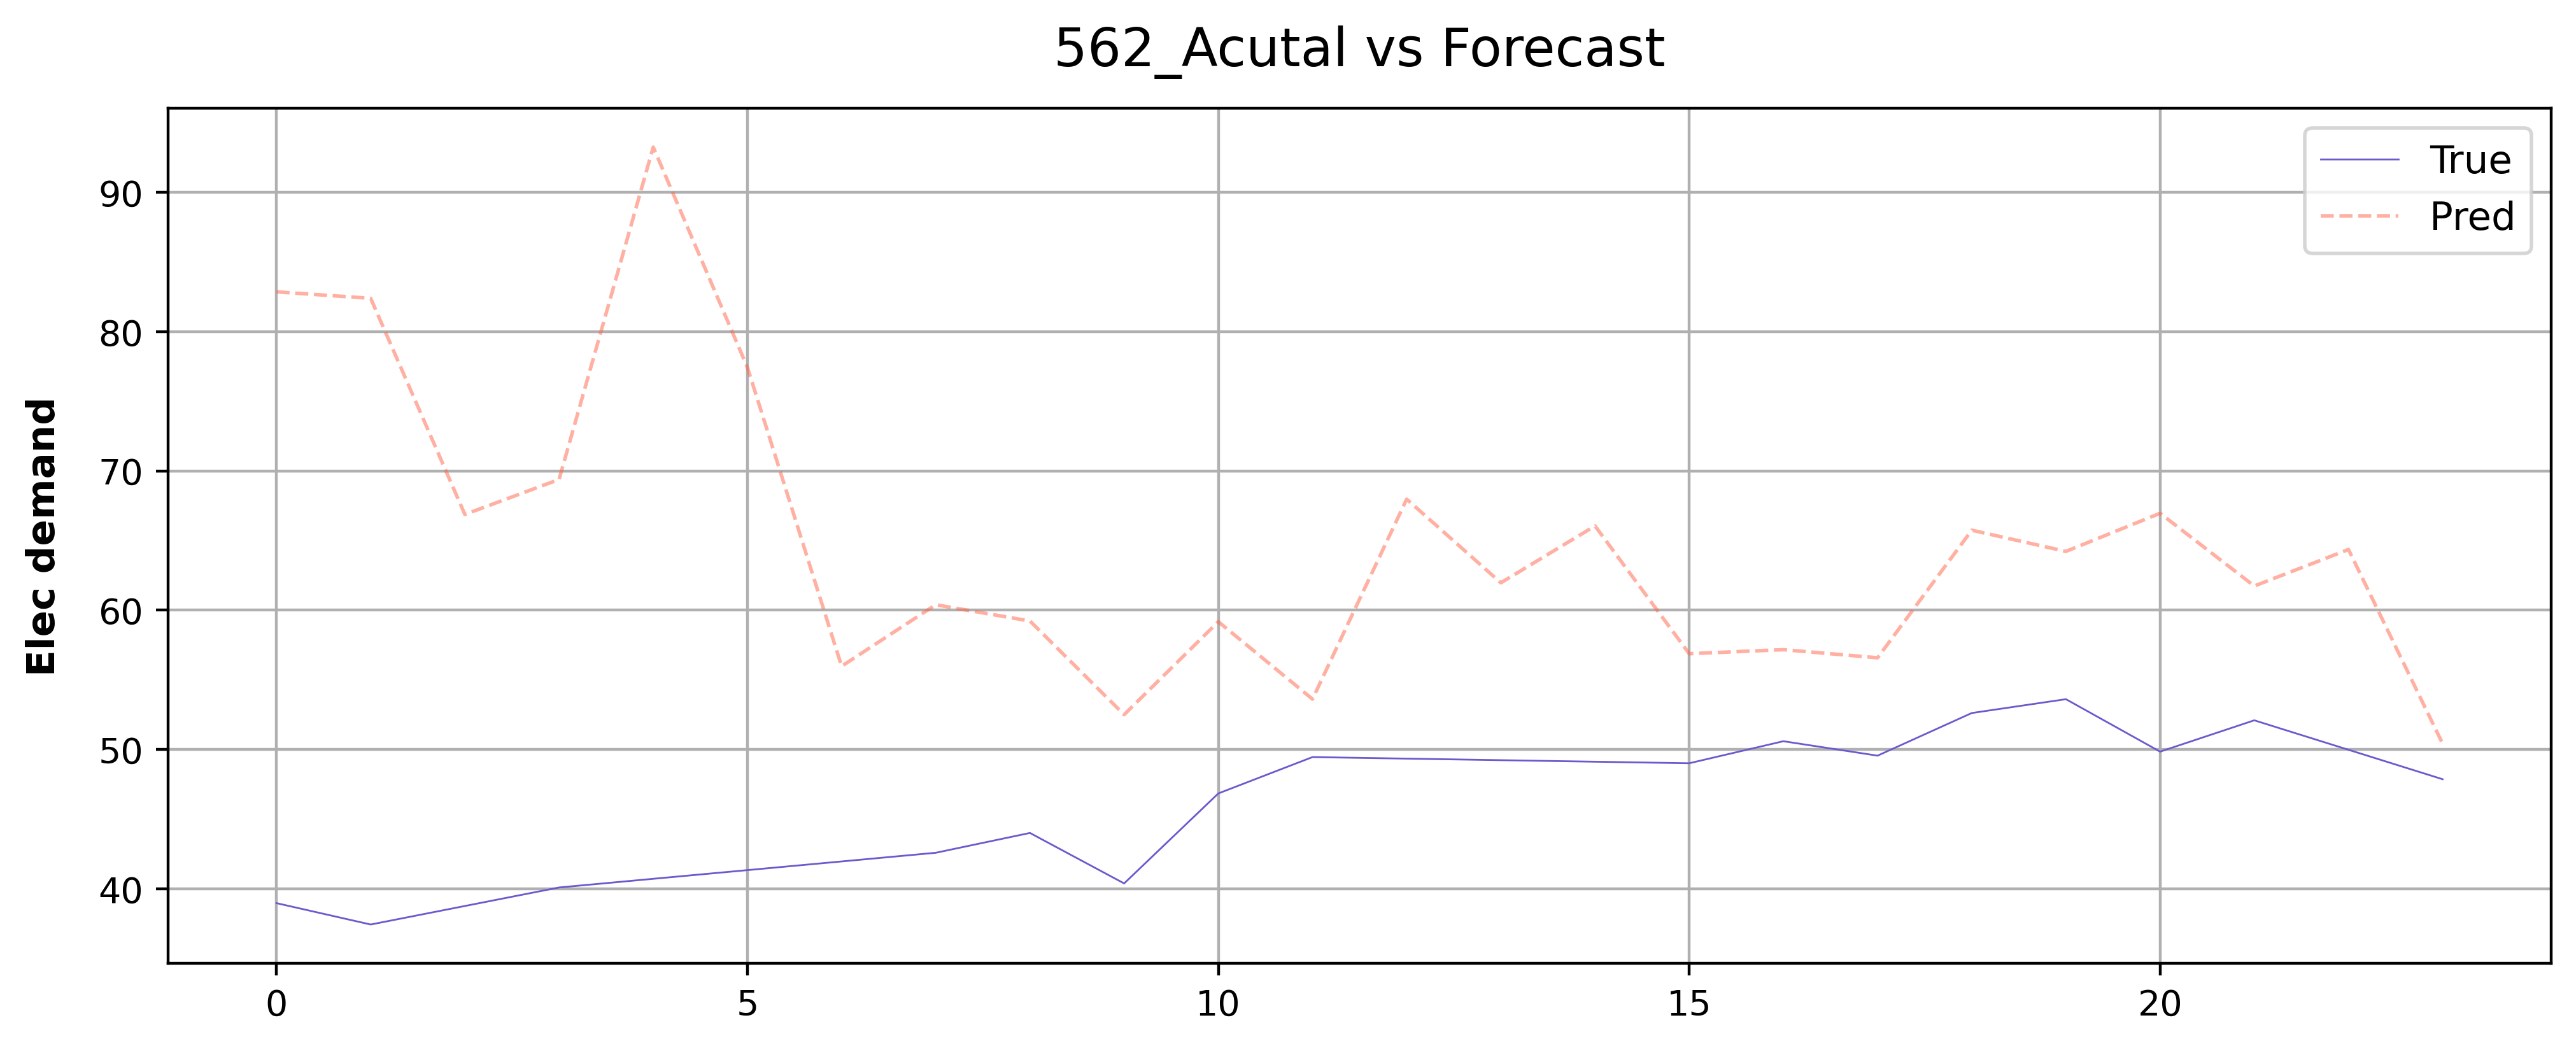

In [49]:
# sns.set_style('ticks')
tick_labelsize=10
legend_fontsize=11
label_fontsize=11

fig_hor = 10

fig = plt.figure(figsize=(fig_hor,4), constrained_layout=True, dpi=400) # 가로 x 세로

ax1 = fig.add_subplot(1,1,1)
ax1.plot(y_true[4], color = 'slateblue', label='True', lw = 0.5, alpha=1.0)
ax1.plot(y_pred[4], color = 'tomato', label='Pred', lw = 1.0, alpha=0.5, linestyle='--')
ax1.set_ylabel('Elec demand', fontweight='bold', fontsize=label_fontsize, labelpad=10)
ax1.set_title('562_Acutal vs Forecast', fontsize=15, pad=12)
ax1.tick_params(axis='x', labelsize=tick_labelsize)
ax1.tick_params(axis='y', labelsize=tick_labelsize)
ax1.legend(loc='best', fontsize=legend_fontsize)
# ax1.set_ylim(-20, 270)
ax1.grid()


plt.show()

In [ ]:
width = 120
tick_labelsize=10
legend_fontsize=11
label_fontsize=11

fig_hor = 10

fig = plt.figure(figsize=(fig_hor,4), constrained_layout=True, dpi=400) # 가로 x 세로

ax1 = fig.add_subplot(1,1,1)

ax1.plot(y_true.squeeze(1)[:width], color = 'slateblue', label='True', lw = 0.5, alpha=1.0)
ax1.plot(y_pred.squeeze(1)[:width], color = 'tomato', label='Pred', lw = 1.0, alpha=0.5, linestyle='--')
ax1.set_ylabel('Elec demand', fontweight='bold', fontsize=label_fontsize, labelpad=10)
ax1.set_title('562_Acutal vs Forecast', fontsize=15, pad=12)
ax1.tick_params(axis='x', labelsize=tick_labelsize)
ax1.tick_params(axis='y', labelsize=tick_labelsize)
ax1.legend(loc='best', fontsize=legend_fontsize)
# ax1.set_ylim(-20, 270)
ax1.grid()


plt.show()

# Test with other data

## Load model

In [ ]:
df_tgt2 = df[['ELEC_561_Ptot']]
df_nontgt2 = df[['MONTH', 'DAY', 'HOUR', 'WEEKDAY', "HOLIDAY"]]

In [ ]:
df_nontgt2['MONTH'] = df_nontgt2['MONTH']/12
df_nontgt2['DAY'] = df_nontgt2['DAY']/31
df_nontgt2['HOUR'] = df_nontgt2['HOUR']/24
df_nontgt2['WEEKDAY'] = df_nontgt2['WEEKDAY']/7

In [ ]:
df_tgt2 = scaler.transform(df_tgt2)

In [ ]:
pred_data = np.concatenate((df_nontgt2, df_tgt2), axis=1)

In [ ]:
print(pred_data.shape)

In [ ]:
pred_set = get_data(pred_data, input_window, output_window, stride)

In [ ]:
def general_predict(model):
    pred_loader = DataLoader(pred_set, batch_size=1, shuffle=False, num_workers=0)
    
    model.eval() # Turn on the evaluation mode
    preds = []
    trues = []
    
    with torch.no_grad():
        for data in pred_loader:            
            src, tgt, y_true = data
            src = src.cuda()
            tgt = tgt.cuda()
            y_true = y_true.cuda()            
            y_pred = model(src, tgt)            
            preds.append(y_pred.cpu().detach().numpy())
            trues.append(y_true.cpu().detach().numpy())       
            
        preds = np.array(preds) 
        trues = np.array(trues)
        preds = preds.reshape(-1, preds.shape[-2], preds.shape[-1])
        trues = trues.reshape(-1, trues.shape[-2], trues.shape[-1])                
            
    return preds, trues

In [ ]:
y_pred2, y_true2 = general_predict(test_model)

In [ ]:
y_pred2 = scaler.inverse_transform(y_pred2)
y_true2 = scaler.inverse_transform(y_true2)

In [ ]:
# sns.set_style('ticks')
tick_labelsize=10
legend_fontsize=11
label_fontsize=11

fig_hor = 10

fig = plt.figure(figsize=(fig_hor,4), constrained_layout=True, dpi=400) # 가로 x 세로

ax1 = fig.add_subplot(1,1,1)
ax1.plot(y_true2.squeeze(1), color = 'slateblue', label='True', lw = 0.5, alpha=1.0)
ax1.plot(y_pred2.squeeze(1), color = 'tomato', label='Pred', lw = 1.0, alpha=0.5, linestyle='--')
ax1.set_ylabel('Elec demand', fontweight='bold', fontsize=label_fontsize, labelpad=10)
ax1.set_title('561_Acutal vs Forecast', fontsize=15, pad=12)
ax1.tick_params(axis='x', labelsize=tick_labelsize)
ax1.tick_params(axis='y', labelsize=tick_labelsize)
ax1.legend(loc='best', fontsize=legend_fontsize)
# ax1.set_ylim(-20, 270)
ax1.grid()


plt.show()

In [ ]:
# sns.set_style('ticks')
tick_labelsize=10
legend_fontsize=11
label_fontsize=11

fig_hor = 10

fig = plt.figure(figsize=(fig_hor,4), constrained_layout=True, dpi=400) # 가로 x 세로

ax1 = fig.add_subplot(1,1,1)
ax1.plot(y_true2.squeeze(1)[:24000], color = 'slateblue', label='True', lw = 0.5, alpha=1.0)
ax1.plot(y_pred2.squeeze(1)[:24000], color = 'tomato', label='Pred', lw = 1.0, alpha=0.5, linestyle='--')
ax1.set_ylabel('Elec demand', fontweight='bold', fontsize=label_fontsize, labelpad=10)
ax1.set_title('561_Acutal vs Forecast', fontsize=15, pad=12)
ax1.tick_params(axis='x', labelsize=tick_labelsize)
ax1.tick_params(axis='y', labelsize=tick_labelsize)
ax1.legend(loc='best', fontsize=legend_fontsize)
# ax1.set_ylim(-20, 270)
ax1.grid()


plt.show()